In [1]:
from robust_mean import M_estimator
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import time
import matplotlib.pyplot as plt
from neurtu import timeit, delayed  

In [4]:
a = time.time()
X = np.random.normal(size=[1000,1000])
result = M_estimator(X, beta=1)
print(time.time()-a)

0.11174249649047852


In [5]:
print(np.linalg.norm(result)) # distance to the mean

1.0155168291969072


# 2D Illustration

In [6]:
N = 60 # Sample size
name = 'Huber'
epsilon = 0.1
center = [20, -1]

np.random.seed(2020)

# Sample dataset from a skewed distribution.
X = np.vstack([np.random.normal(size= [3*N//4,2]), 
              3+np.random.normal(size= [(N//4),2])])

# Contaminate with outliers
for f in np.arange(int(len(X)*epsilon)):
    X[f] = np.random.normal(size=2)+np.array(center)


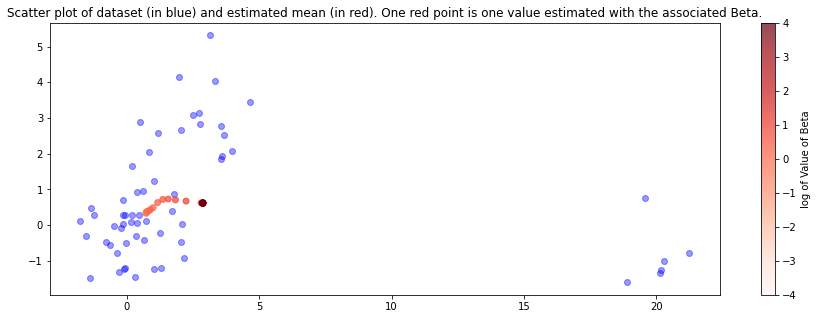

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

# define the estimators
estimated_values = []
for beta in np.logspace(-4,4):
    estimated_values += [M_estimator(X, beta, name, p=4)]

plt.scatter(X[:,0],X[:,1],alpha = 0.4, c='b')    
im = plt.scatter(np.array(estimated_values)[:,0], 
            np.array(estimated_values)[:,1], 
            cmap = plt.get_cmap('Reds'), 
            c = np.linspace(-4,4), alpha = 0.7)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('log of Value of Beta')


ax.set_title('Scatter plot of dataset (in blue) and estimated mean (in red).'
             ' One red point is one value estimated with the associated Beta.')

plt.show()

# Heavy tail illustration

In [8]:


def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1
        
def pareto(df, n, d):
    return (np.random.pareto(df, size=[n,d])+1)

def gmom(X, K):
    perm = np.random.permutation(len(X))
    blocks = np.array_split(perm, K)
    return geometric_median(np.array([np.mean(X[b], axis=0) for b in blocks]))

In [10]:
res = []
alpha = 2.1
power = 2
n = 1000
d = 100
mean = alpha/(alpha -1)*np.ones(d)
M = 20

for iteration in range(M):
    print("\r"+str(iteration), end="" )
    X = pareto(alpha, n, d)
    X = np.vstack([X, 300*np.ones([2,d])])
    res += [ [np.linalg.norm(M_estimator(X)-mean),
              np.linalg.norm(M_estimator(X, name= "Catoni")-mean),
              np.linalg.norm(M_estimator(X, name= "Polynomial", p=5)-mean),
            np.linalg.norm(gmom(X, 9) - mean), 
            np.linalg.norm(geometric_median(X)-mean)]]

19

Text(0, 0.5, 'Error')

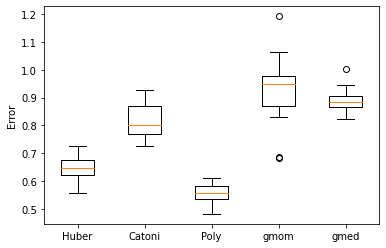

In [11]:
plt.boxplot(np.array(res), labels= ['Huber', 'Catoni', 'Poly', "gmom", "gmed"])
plt.ylabel('Error')